<font size="+3"><strong>Volatility Forecasting in FrankFurt</strong></font>

In this assignment you'll build a model to predict stock volatility for the telecommunications company [Vodafone Group](https://www.mtn.co.za/home/).

In [12]:
# Import your libraries here
import os
import sqlite3
from glob import glob

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# from arch.univariate.base import ARCHModelResult
from config import settings

from data import SQLRepository

from arch import arch_model
from config import settings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Checking API

In [ ]:
import requests

url = ''
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': '5VD.FRK', '3. Last Refreshed': '2025-04-03', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-04-03': {'1. open': '6.1000', '2. high': '6.1000', '3. low': '6.1000', '4. close': '6.1000', '5. volume': '2500'}, '2025-04-02': {'1. open': '6.4000', '2. high': '6.4000', '3. low': '6.4000', '4. close': '6.4000', '5. volume': '2500'}, '2025-04-01': {'1. open': '6.3000', '2. high': '6.3000', '3. low': '6.3000', '4. close': '6.3000', '5. volume': '2500'}, '2025-03-31': {'1. open': '6.0500', '2. high': '6.0500', '3. low': '6.0500', '4. close': '6.0500', '5. volume': '2500'}, '2025-03-28': {'1. open': '6.1000', '2. high': '6.1000', '3. low': '6.1000', '4. close': '6.1000', '5. volume': '2500'}, '2025-03-27': {'1. open': '6.0500', '2. high': '6.0500', '3. low': '6.0500', '4. close': '6.0500', '5. volume': '2500'}, '2025-03-26': {'1. open': '6.2000', '2. hig

In [5]:
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [6]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

In [5]:
%load_ext autoreload
%autoreload 2

# from arch.univariate.base import ARCHModelResult

## Extract Data From API

Create a URL to extract stock data for Vodafone Group Frankfurt

In [ ]:
ticker = "5VD.FRK"
output_size = "full"
data_type = "json"
api_key = settings.ALPHA_VANTAGE_API_KEY

url = (
    'https://www.alphavantage.co/query?'
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
    f"apikey={api_key}"
)
# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=5VD.FRK&apikey=I5UHTNS8H3YLJR02&outputsize=full&datatype=json'
print("url type:", type(url))
url

url type: <class 'str'>


'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=5VD.FRK&outputsize=full&datatype=json&apikey=I5UHTNS8H3YLJR02'

In [8]:
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [9]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

## Clean the data

In [ ]:
response_data = response.json()
stock_data = response_data['Time Series (Daily)']

df_vodf = pd.DataFrame.from_dict(stock_data, orient="index", dtype=float)

# Convert date index to `DatetimeIndex`
df_vodf.index = pd.to_datetime(df_vodf.index)

# Remove numbering from column names
df_vodf.columns = [c.split(". ")[1] for c in df_vodf.columns]

# Name index "date"
df_vodf.index.name = "date"

print("df_vodf type:", type(df_vodf))
df_vodf.head()

df_vodf type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2025-04-03,6.10,6.10,6.10,6.10,2500.0
2025-04-02,6.40,6.40,6.40,6.40,2500.0
2025-04-01,6.30,6.30,6.30,6.30,2500.0
2025-03-31,6.05,6.05,6.05,6.05,2500.0
2025-03-28,6.10,6.10,6.10,6.10,2500.0


## Save Stock Data to an SQLITE3 Database

In [11]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
connection

In [ ]:
# Insert `VOD_F` data into database
repo = SQLRepository(connection=connection)
repo.insert_table(table_name='VOD_F', records=df_vodf)

{'transaction_successful': True, 'records_inserted': 3823}

In [ ]:
# Get first five rows of `VOD_F` table
data_check = pd.read_sql(sql="SELECT * FROM VOD_F LIMIT 5", con=connection)
data_check

,date,open,high,low,close,volume
0,2025-04-03 00:00:00,6.10,6.10,6.10,6.10,2500.0
1,2025-04-02 00:00:00,6.40,6.40,6.40,6.40,2500.0
2,2025-04-01 00:00:00,6.30,6.30,6.30,6.30,2500.0
3,2025-03-31 00:00:00,6.05,6.05,6.05,6.05,2500.0
4,2025-03-28 00:00:00,6.10,6.10,6.10,6.10,2500.0


In [19]:
df_vodf_read = repo.read_table("VOD_F")

print("df_vodf_read type:", type(df_vodf_read))
print("df_vodf_read shape:", df_vodf_read.shape)
df_vodf_read.head()

df_vodf_read type: <class 'pandas.core.frame.DataFrame'>
df_vodf_read shape: (3823, 5)


,open,high,low,close,volume
date,,,,,
2025-04-03,6.10,6.10,6.10,6.10,2500.0
2025-04-02,6.40,6.40,6.40,6.40,2500.0
2025-04-01,6.30,6.30,6.30,6.30,2500.0
2025-03-31,6.05,6.05,6.05,6.05,2500.0
2025-03-28,6.10,6.10,6.10,6.10,2500.0


# Predicting Volatility

## Prepare Data

In [21]:

y_vodf = df_vodf_read['high'][:2500]

print("y_vodf type:", type(y_vodf))
print("y_vodf shape:", y_vodf.shape)
y_vodf.head()

y_vodf type: <class 'pandas.core.series.Series'>
y_vodf shape: (2500,)


date
2025-04-03    6.10
2025-04-02    6.40
2025-04-01    6.30
2025-03-31    6.05
2025-03-28    6.10
Name: high, dtype: float64

Calculate daily volatility for `y_vodf`

In [22]:
vodf_daily_volatility = y_vodf.std()
print("vodf_daily_volatility type:", type(vodf_daily_volatility))
print("Vodafone Daily Volatility:", vodf_daily_volatility)

vodf_daily_volatility type: <class 'numpy.float64'>
Vodafone Daily Volatility: 1.8034201725785883


Calculate the annual volatility for `y_vodf`

In [25]:
vodf_annual_volatility = vodf_daily_volatility * np.sqrt(252)

print("vodf_annual_volatility type:", type(vodf_annual_volatility))
print("Vodafone Annual Volatility:", vodf_annual_volatility)

vodf_annual_volatility type: <class 'numpy.float64'>
Vodafone Annual Volatility: 28.628407716000783


Create a time series line plot for `y_vodf`

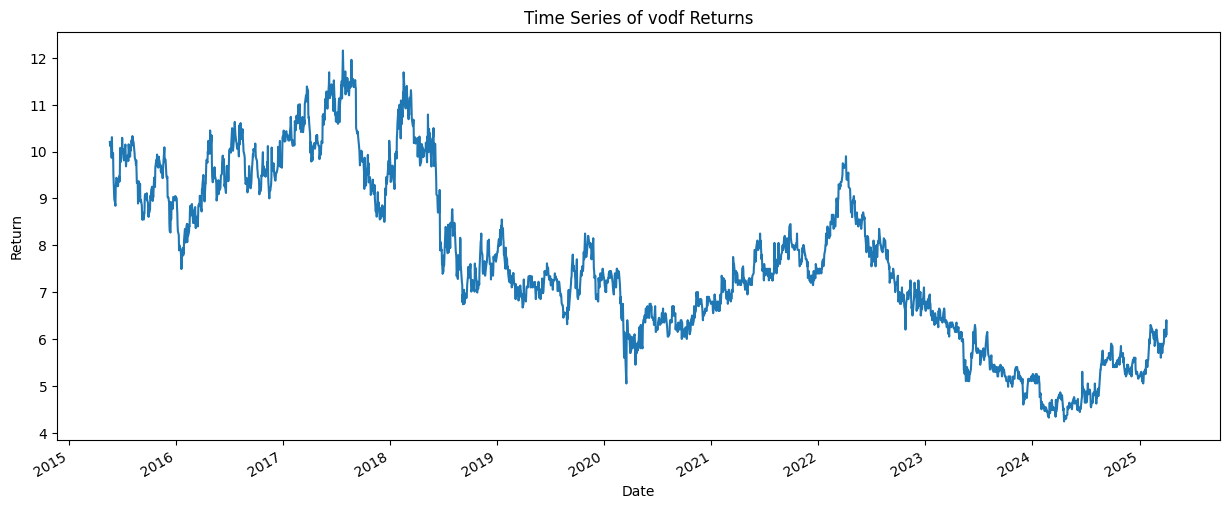

In [29]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_vodf` on `ax`
y_vodf.plot(ax=ax, label="vodf")

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Return")

# Add title
plt.title("Time Series of vodf Returns")

# Don't delete the code below 👇
plt.savefig("images/1.png", dpi=150)


Create an ACF plot of the squared returns for Vodafone.

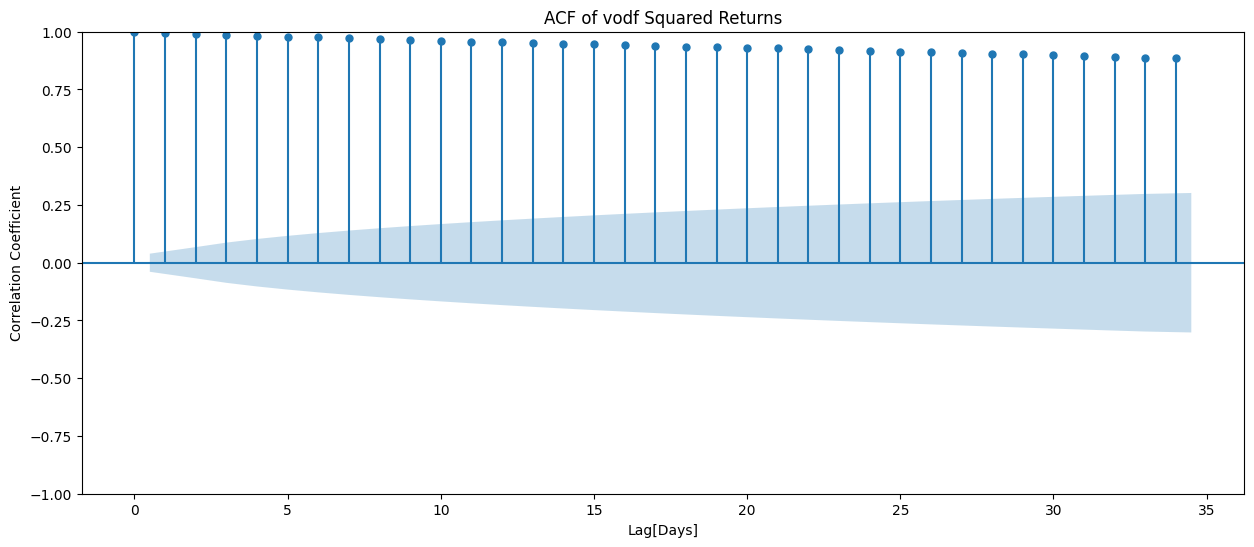

In [30]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_vodf**2, ax=ax)

# Add axis labels
plt.xlabel("Lag[Days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("ACF of vodf Squared Returns")

# Don't delete the code below 👇
plt.savefig("images/2.png", dpi=150)


Create a PACF plot of the squared returns for Vodafone

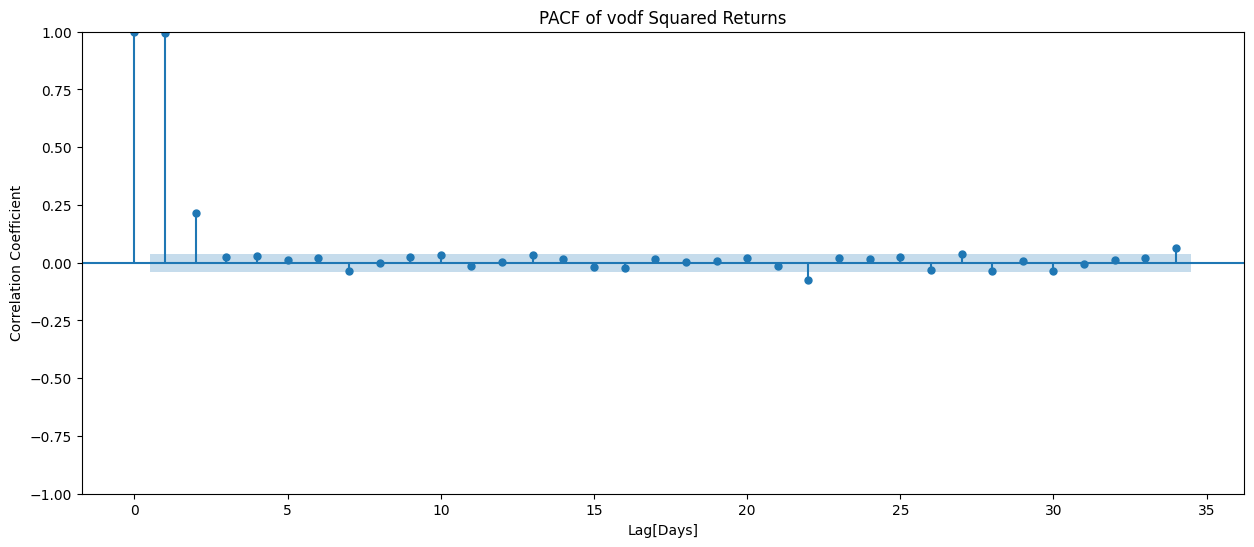

In [31]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_pacf(y_vodf**2, ax=ax)

# Add axis labels
plt.xlabel("Lag[Days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("PACF of vodf Squared Returns")

# Don't delete the code below 👇
plt.savefig("images/3", dpi=150)


**Task 8.5.14:** Create a training set `y_vodf_train` that contains the first 80% of the observations in `y_vodf`. 

In [33]:
cutoff = int(len(y_vodf) * 0.8)
y_vodf_train = y_vodf.iloc[:cutoff]

print("y_vodf_train type:", type(y_vodf_train))
print("y_vodf_train shape:", y_vodf_train.shape)
y_vodf_train.head()

y_vodf_train type: <class 'pandas.core.series.Series'>
y_vodf_train shape: (2000,)


date
2025-04-03    6.10
2025-04-02    6.40
2025-04-01    6.30
2025-03-31    6.05
2025-03-28    6.10
Name: high, dtype: float64

## Model Building

Build and fit a GARCH model using the data in `y_vodf`.

In [34]:
# Build and train model
model = arch_model(
    y_vodf_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>
model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   high   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2558.89
Distribution:                  Normal   AIC:                           5125.77
Method:            Maximum Likelihood   BIC:                           5148.17
                                        No. Observations:                 2000
Date:                Fri, Apr 04 2025   Df Residuals:                     1999
Time:                        18:53:01   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             7.2063  2.730e-02    263.977      0.000 [  7.153,  7.260]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0105  1.946e-03      5.389  7.074e-08 [6.674e-03,1.430e-02]
alpha[1]       0.7476  4.992e-02     14.976  1.057e-50     [  0.650,  0.845]
beta[1]        0.2524  5.035e-02      5.013  5.348e-07     [  0.154,  0.351]
============================================================================

Covariance estimator: robust
"""

Plot the standardized residuals for your `model`.

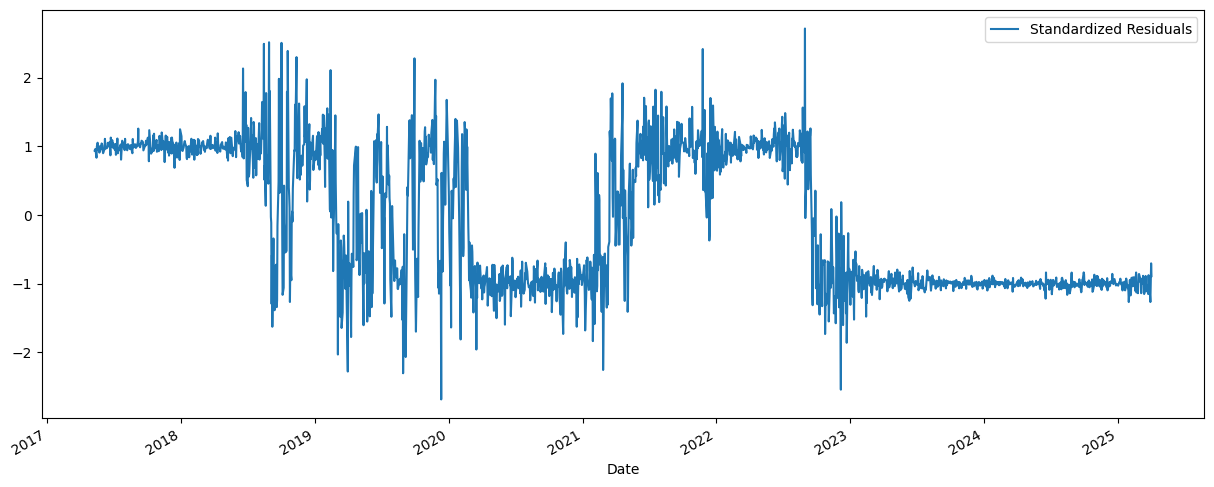

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

# Don't delete the code below 👇
plt.savefig("images/4.png", dpi=150)


Lets Create an ACF plot of the squared, standardized residuals of the `model`.

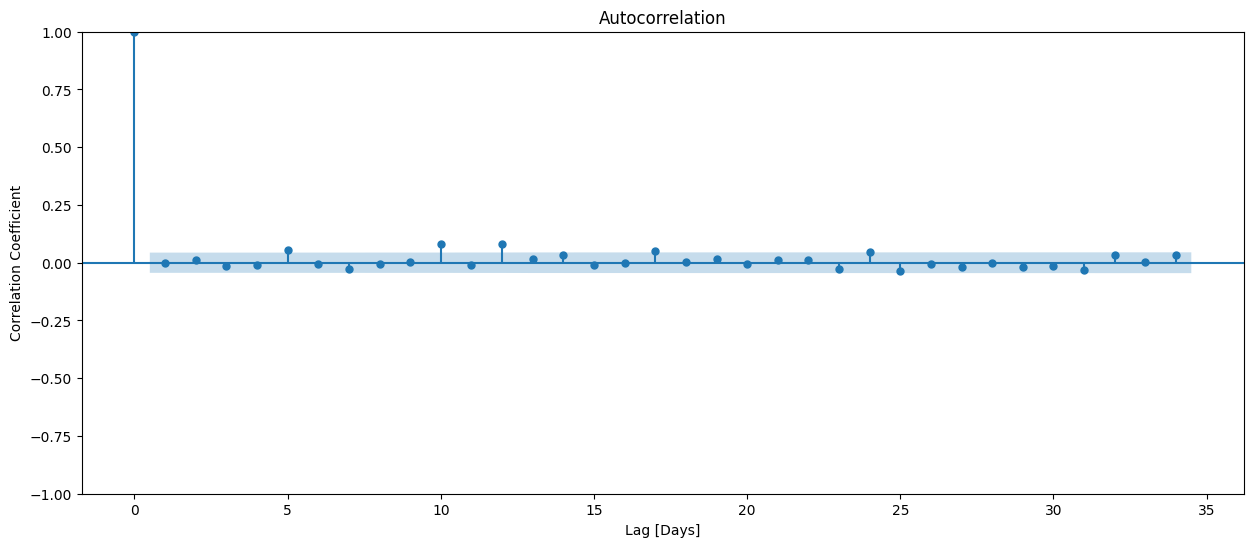

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals

plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient")

# Don't delete the code below 👇
plt.savefig("images/5.png", dpi=150)


# Model Deployment

In [1]:
# Import `build_model` function
from main import build_model

# Build model using new `vodf` data
model = build_model(ticker="5VD.FRK", use_new_data=True)

# Wrangle `vodf` returns
model.wrangle_data(n_observations=2500)

# Fit GARCH(1,1) model to data
model.fit(p=1, q=1)

# Check if model have AIC and BIC attributes?
assert hasattr(model, "aic")
assert hasattr(model, "bic")

In [2]:
# Import `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="5VD.FRK", use_new_data=True, n_observations=2500, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

{'ticker': '5VD.FRK',
 'use_new_data': True,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and Saved 'models\\2025-04-04T19-56-52.382403_5VD.FRK.pkl'."}

Lets create a `post` request to hit the `"/fit"` path running at `"http://localhost:8008"`.

In [9]:
# URL of `/fit` path
url = "http://localhost:8080/fit"
# Data to send to path
json = {
    "ticker": "5VD.FRK",
    "use_new_data": False,
    "n_observations": 2500,
    "p": 1,
    "q": 1
}
# Response of post request
response = response = requests.post(url=url, json=json)

# Inspect response
print("response code:", response.status_code)
response.json()
print("response type:", type(response))
print("response status code:", response.status_code)

response code: 200
response type: <class 'requests.models.Response'>
response status code: 200


Creating a `post` request to hit the `"/predict"` path running at `"http://localhost:8008"`.

In [11]:
# URL of `/predict` path
url = "http://localhost:8080/predict"
# Data to send to path
json = json = {"ticker": "vodf", "n_days":5}
# Response of post request
response =  requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 500
